# CSCI 349 - Final Project Report
**Authors:** Nick Satriano, Jake Luther, and Jake Etzler  
**Date:** May 2nd  
**Semester:** Spring 2023  
**Instructor:** Brian King  

**Link to Project Repo:** https://gitlab.bucknell.edu/nas022/csci349_2023sp/-/tree/main/final_project

## Introduction

We are mining historical data from the United States Stock Market to determine how well we can predict the daily trends of stock prices. The stock tickers that we chose to model are **PNM**, **GALT**, and **AMZN**, which represent the following companies in respective order: PNM Resources Inc, Galectin Therapeutics Inc, and Amazon.

In [128]:
# import list
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc, confusion_matrix
import seaborn as sns
import datetime
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import calendar

## Data

We are using data from a github repository called yfinance which is a python package used for downloading Yahoo! Finance market data. This dataset contains historical data of every stock on the US Stock Market and we can selectively choose to import data of specific stock tickers, or pull from different date ranges depending on our needs. 

Each observation in the data represents a set of daily measures for each stock. This dataframe has multi-level column names, meaning that the observations for each stock are grouped together on the same row, representing a single date, but all of their attributes are contained in a block of columns under the given stock name. 

The attributes for each stock on each day are reported in the data as follows:  
1) Date (the index): tells us the date of recording for each observation
2) Open: a float representing the value of the stock when trading opens for the day
3) High: a float representing the highest value of the stock for the day
4) Low: a float representing the lowest value of the stock for the day
5) Close: a float representing the value of the stock when trading closes for the day
7) Volume: an integer representing the total number of the ticker's stocks traded for the day. 
8) Dividends: a float representing the number of dividends paid out by the company for the day.
9) Stock Splits: a float representing the number of stock splits for the day.

The key target variable for us here is the **Close** price variable, as we believe that it provides the most accurate price of a stock out of all the other measures in the DataFrame. That being said, we have used the Close variable to create moving averages  and another variable named **Target** which holds a 1 value if the close price of a stock on the following day is higher than the close price of the stock today, and a 0 if the close price is lower. Because of this, the **Target** variable is now considered our key target variable.

In [30]:
# selecting the PNM ticker data for the pnm_raw dataframe
pnm_raw = yf.Ticker("PNM")

# changing the dataframe into the historical data for the PNM ticker
pnm_raw = pnm_raw.history(period="max")

print("Raw dataset for the PNM ticker:")
pnm_raw

Raw dataset for the PNM ticker:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1973-02-21 00:00:00-05:00,0.000000,3.960075,3.873986,3.960075,5700,0.000,0.0
1973-02-22 00:00:00-05:00,0.000000,3.960076,3.917032,3.938554,1350,0.000,0.0
1973-02-23 00:00:00-05:00,0.000000,3.895509,3.852465,3.873987,2550,0.000,0.0
1973-02-26 00:00:00-05:00,0.000000,3.873987,3.809420,3.873987,4050,0.000,0.0
1973-02-27 00:00:00-05:00,0.000000,3.873985,3.809419,3.830941,2100,0.000,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00-04:00,48.560001,48.660000,48.189999,48.299999,436300,0.368,0.0
2023-04-28 00:00:00-04:00,48.200001,48.470001,47.950001,48.130001,390000,0.000,0.0
2023-05-01 00:00:00-04:00,48.020000,48.130001,47.950001,48.029999,300900,0.000,0.0


In [31]:
# selecting the GALT ticker data for the galt_raw dataframe
galt_raw = yf.Ticker("GALT")

# changing the dataframe into the historical data for the PNM ticker
galt_raw = galt_raw.history(period="max")

print("Raw dataset for the GALT ticker:")
galt_raw

Raw dataset for the GALT ticker:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-09-04 00:00:00-04:00,12.000000,12.00,12.000000,12.00,733,0.0,0.0
2002-09-05 00:00:00-04:00,12.000000,12.00,12.000000,12.00,250,0.0,0.0
2002-09-06 00:00:00-04:00,12.000000,21.00,12.000000,21.00,533,0.0,0.0
2002-09-09 00:00:00-04:00,18.000000,18.00,12.000000,12.00,183,0.0,0.0
2002-09-10 00:00:00-04:00,19.200001,19.50,19.200001,19.50,33,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00-04:00,1.750000,1.77,1.710000,1.74,66000,0.0,0.0
2023-04-28 00:00:00-04:00,1.700000,1.78,1.700000,1.76,49100,0.0,0.0
2023-05-01 00:00:00-04:00,1.770000,1.84,1.710000,1.71,26300,0.0,0.0


In [32]:
# selecting the AMZN ticker data for the amzn_raw dataframe
amzn_raw = yf.Ticker("AMZN")

# changing the dataframe into the historical data for the PNM ticker
amzn_raw = amzn_raw.history(period="max")

print("Raw dataset for the AMZN ticker:")
amzn_raw

Raw dataset for the AMZN ticker:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00-04:00,108.160004,110.860001,106.800003,109.820000,149961200,0.0,0.0
2023-04-28 00:00:00-04:00,107.730003,109.480003,104.330002,105.449997,130565000,0.0,0.0
2023-05-01 00:00:00-04:00,104.949997,105.230003,101.820000,102.050003,74728100,0.0,0.0


## Data Preparation

To clean our data for modeling, we first deleted the **Dividends** and **Stock Splits** variables from the stock ticker dataframes. Though these are important measures for individual stocks, we did not end up using these variables as predictors for our modeling.

Next, we created a new variable in the dataframes named **Tomorrow**, which contains the closing price of the stock one day in the future.

From there, we created another new variable named **Target**, which contains a 0 for each row where the **Tomorrow** price is lower than the closing price of the current observation, and a 1 for each row where the **Tomorrow** price is greater than the closing price of the current observation.

For stock ticker dataframes that contain data recorded earlier than 1990, we chose to remove that data from the dataframe entirely. This is because the 1970's and 1980's data contain some odd overall trends and we do not want these trends to influence the ability of our model to make modern predictions.

Lastly, we created additional variables containing the **Close Ratio** and **Trend** for the following ranges of rolling averages for **Close** price: 2 days, 5 days, 60 days, 250 days, and 1000 days. The **Close Ratio** variable is the current day's **Close** price divided by the specified rolling average. The **Trend** variable tells us the number of days the stock ticker's **Close** price actually increased over the period specified by the rolling average. After creating these variables, we finished cleaning our dataframe by removing all NA values.

In [131]:
# function to help us plot the data
def plot_target_by_month(name, df):
    df['Month'] = df.index.month
    df_positive = df[df['Target']==1]
    df_negative = df[df['Target'] == 0]
    pos_by_month = df_positive['Month'].value_counts().sort_index()
    pos_by_month = pos_by_month.rename('PosNumber')
    neg_by_month = df_negative['Month'].value_counts().sort_index()
    neg_by_month = neg_by_month.rename('NegNumber')
    month_df = pd.DataFrame(index = pos_by_month.index)
    month_df = pd.concat([pos_by_month, neg_by_month], axis=1)
    month_df = month_df.melt(var_name="Target", value_name="Number", ignore_index=False)
    month_df = month_df.set_index(pd.Series(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                                            'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))
    figure = plt.figure(figsize=(13,6))
    fig_palette = sns.color_palette(['#00cc00', '#ff0000'])#ff3333'])
    ax = sns.barplot(data = month_df, x=month_df.index, y="Number", hue="Target", palette=fig_palette)

    for i, val in enumerate(month_df['Number']):
        if i < 12:
            ax.text(i-0.2, val+1, str(val), ha='center', size=10)
        else:
            ax.text(i-12+0.2, val+1, str(val), ha='center', size=10)
        
    plt.title("Positive vs Negative Target Values By Month of " + name + " Model")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.legend(loc="lower right")
    plt.show()

In [138]:
# another helper function to display the target values in our visualizations
def display_target_values(name, df):
    num_pos = len(df[df['Target']==1])
    num_neg = len(df[df['Target']==0])
    val_nums = [num_pos, num_neg]
    labels = ['Positive', 'Negative']
    sns.set_style('whitegrid')
    plt.figure(figsize=(5,5))
    palette = sns.color_palette(['#00cc00', '#ff0000'])
    wedges, texts, autotexts = plt.pie(val_nums, labels=labels, autopct='%1.1f%%', startangle=90, colors=palette, textprops=dict(color="w", fontsize=14, fontweight='bold'))
    plt.axis('equal')
    plt.title('Percentage Positive vs. Negative of ' + name + ' Ticker Target')
    plt.show()

In [142]:
# another helper
def plot_target_by_year(name, df):
    target_df = df[['Target']].resample('Y').sum()
    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=target_df, x=target_df.index, y='Target', color='#00cc00')
    plt.xlabel('Year')
    plt.ylabel("Number of times " + name + "Ticker's Target is Positive")
    plt.title('Target Occurrences per Year')
    plt.show()

**Data Prep / EDA for PNM:**

In [97]:
# Prepare PNM data for modeling
pnm = pnm_raw.copy()

# Delete the Dividends and Stock Splits variables
del pnm["Dividends"]
del pnm["Stock Splits"]

# Creating the Tomorrow variable in the dataframe
pnm["Tomorrow"] = pnm["Close"].shift(-1)

# Creating the Target variable in the dataframe
pnm["Target"] = (pnm["Tomorrow"] > pnm["Close"]).astype(int)

# Shrinking our PNM dataset to only include 1990 to the present
pnm = pnm.loc["1990-01-01":].copy()

# creating moving average day-splits list
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_avgs = pnm.rolling(horizon).mean()
    
    ratio_col = f"Close Ratio {horizon}"
    pnm[ratio_col] = pnm["Close"] / rolling_avgs["Close"]
    
    trend_col = f"Trend {horizon}"
    pnm[trend_col] = pnm.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_col, trend_col]
    
pnm = pnm.dropna()

print('PNM prep completed\n')

# Showing the summary statistics of the PNM dataframe
print("Summary statistics for the PNM ticker:")
pnm.describe()

PNM prep completed

Summary statistics for the PNM ticker:


,Open,High,Low,Close,Volume,Tomorrow,Target,Close Ratio 2,Trend 2,Close Ratio 5,Trend 5,Close Ratio 60,Trend 60,Close Ratio 250,Trend 250,Close Ratio 1000,Trend 1000
count,7398.000000,7398.000000,7398.000000,7398.000000,7.398000e+03,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000,7398.000000
mean,17.626946,17.788013,17.463865,17.631962,5.209079e+05,17.638065,0.488916,1.000190,0.977832,1.000822,2.444444,1.012563,29.322384,1.051581,121.558665,1.207424,478.655177
std,13.731058,13.811874,13.646386,13.733418,6.207325e+05,13.736885,0.499911,0.008914,0.706137,0.019082,1.128769,0.071863,5.069080,0.142881,16.647138,0.266873,66.889859
min,2.825223,2.894131,2.790770,2.859678,1.215000e+04,2.859678,0.000000,0.858256,0.000000,0.772717,0.000000,0.521794,14.000000,0.386939,74.000000,0.302025,330.000000
25%,6.781679,6.878803,6.679017,6.790427,2.377500e+05,6.795513,0.000000,0.996406,0.000000,0.992579,2.000000,0.980837,26.000000,0.974771,113.000000,1.082956,459.000000
50%,12.806175,12.931620,12.678798,12.817997,4.020000e+05,12.836277,0.000000,1.000000,1.000000,1.001067,2.000000,1.016049,30.000000,1.063132,127.000000,1.247503,509.000000
75%,24.553565,24.887051,24.272214,24.602483,6.379750e+05,24.629851,1.000000,1.004255,1.000000,1.009621,3.000000,1.052107,33.000000,1.139860,132.000000,1.390536,527.000000
max,51.023938,51.188061,50.850698,50.868935,2.487620e+07,50.868935,1.000000,1.077988,2.000000,1.207870,5.000000,1.341463,43.000000,1.623249,153.000000,1.974018,547.000000


Number of Positive vs. Negative Target Values By Month of PNM Data:


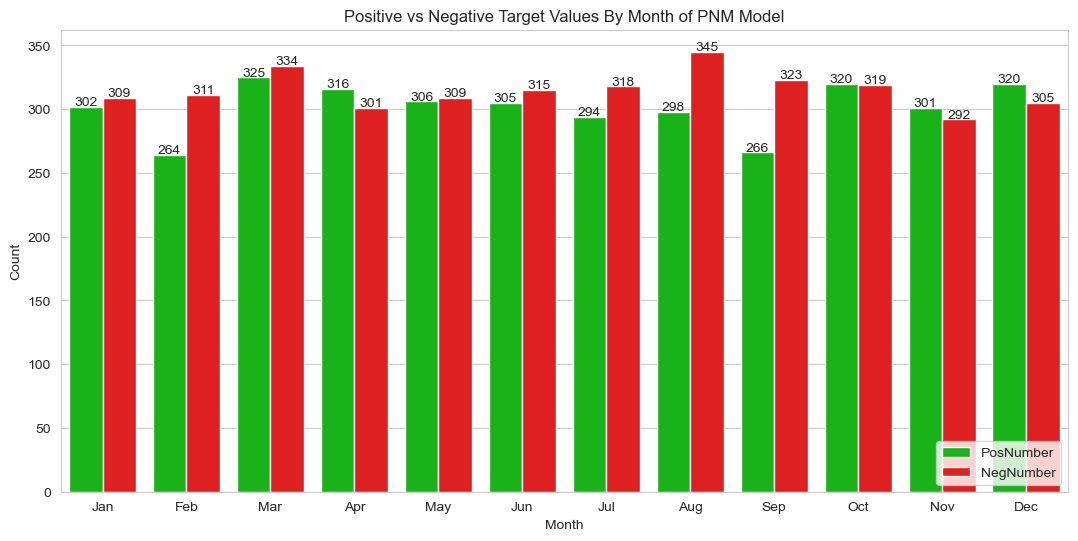

In [135]:
# plotting the PNM Target variable
print("Number of Positive vs. Negative Target Values By Month of PNM Data:")
plot_target_by_month("PNM", pnm)

Percentage of Positive vs Negative Target Values of PNM Ticker


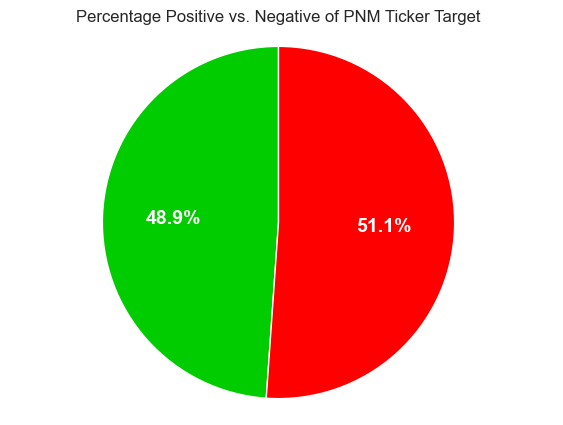

In [139]:
print("Percentage of Positive vs Negative Target Values of PNM Ticker")
display_target_values("PNM", pnm)

Number of Times PNM Ticker's Target is Positive Per Year:


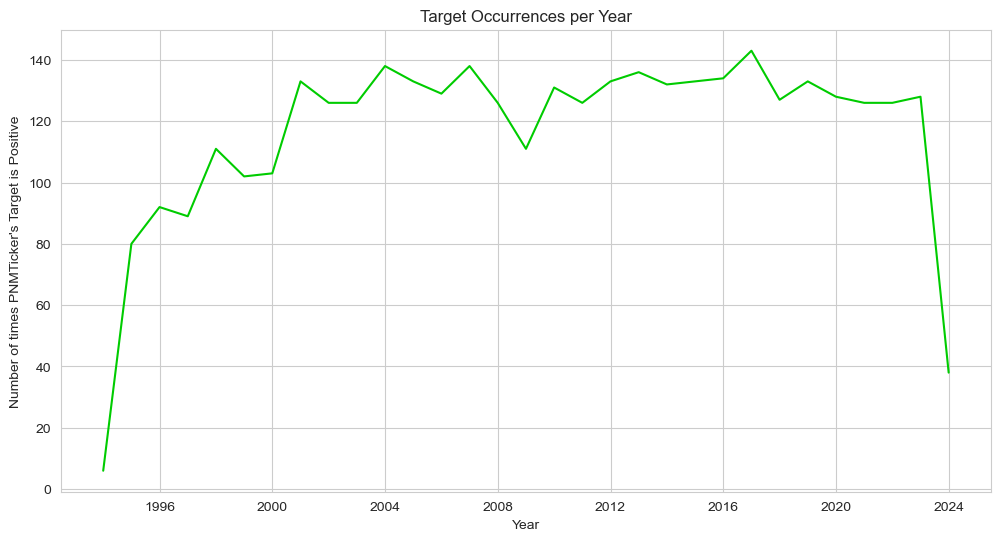

In [145]:
print("Number of Times PNM Ticker's Target is Positive Per Year:")
plot_target_by_year("PNM", pnm)

**Data Prep / EDA for GALT:**

In [99]:
# Prepare GALT data for modeling
galt = galt_raw.copy()

# Delete the Dividends and Stock Splits variables
del galt["Dividends"]
del galt["Stock Splits"]

# Creating the Tomorrow variable in the dataframe
galt["Tomorrow"] = galt["Close"].shift(-1)

# Creating the Target variable in the dataframe
galt["Target"] = (galt["Tomorrow"] > galt["Close"]).astype(int)

# creating moving average day-splits list
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_avgs = galt.rolling(horizon).mean()
    
    ratio_col = f"Close Ratio {horizon}"
    galt[ratio_col] = galt["Close"] / rolling_avgs["Close"]
    
    trend_col = f"Trend {horizon}"
    galt[trend_col] = galt.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_col, trend_col]
    
galt = galt.dropna()

print('GALT prep completed\n')

# Showing the summary statistics of the GALT dataframe
print("Summary statistics for the GALT ticker:")
galt.describe()

GALT prep completed

Summary statistics for the GALT ticker:


,Open,High,Low,Close,Volume,Tomorrow,Target,Close Ratio 2,Trend 2,Close Ratio 5,Trend 5,Close Ratio 60,Trend 60,Close Ratio 250,Trend 250,Close Ratio 1000,Trend 1000
count,4201.000000,4201.000000,4201.000000,4201.000000,4.201000e+03,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000,4201.000000
mean,3.668462,3.815996,3.507436,3.659164,2.681537e+05,3.657879,0.415139,0.999867,0.830279,1.000235,2.075220,1.002099,24.820281,0.983236,103.314211,0.866620,415.190907
std,2.577628,2.682910,2.467827,2.571634,1.984057e+06,2.571273,0.492805,0.033107,0.687644,0.072492,1.091987,0.266620,4.411384,0.467585,12.539188,0.666943,37.290280
min,0.300000,0.480000,0.300000,0.360000,3.000000e+02,0.360000,0.000000,0.563241,0.000000,0.454111,0.000000,0.281690,13.000000,0.128590,75.000000,0.038867,348.000000
25%,2.040000,2.110000,1.970000,2.040000,2.390000e+04,2.040000,0.000000,0.985075,0.000000,0.966567,1.000000,0.842734,21.000000,0.633616,92.000000,0.358531,379.000000
50%,2.870000,2.960000,2.750000,2.860000,8.860000e+04,2.860000,0.000000,1.000000,1.000000,0.994475,2.000000,0.966130,25.000000,0.896074,105.000000,0.625472,417.000000
75%,4.530000,4.740000,4.360000,4.530000,2.254000e+05,4.520000,1.000000,1.012613,1.000000,1.024372,3.000000,1.114764,28.000000,1.281049,113.000000,1.265800,452.000000
max,18.510000,19.110001,17.559999,18.299999,1.042588e+08,18.299999,1.000000,1.272727,2.000000,1.920732,5.000000,2.855187,35.000000,3.020451,127.000000,3.529021,466.000000


Number of Positive vs. Negative Target Values By Month of GALT Model:


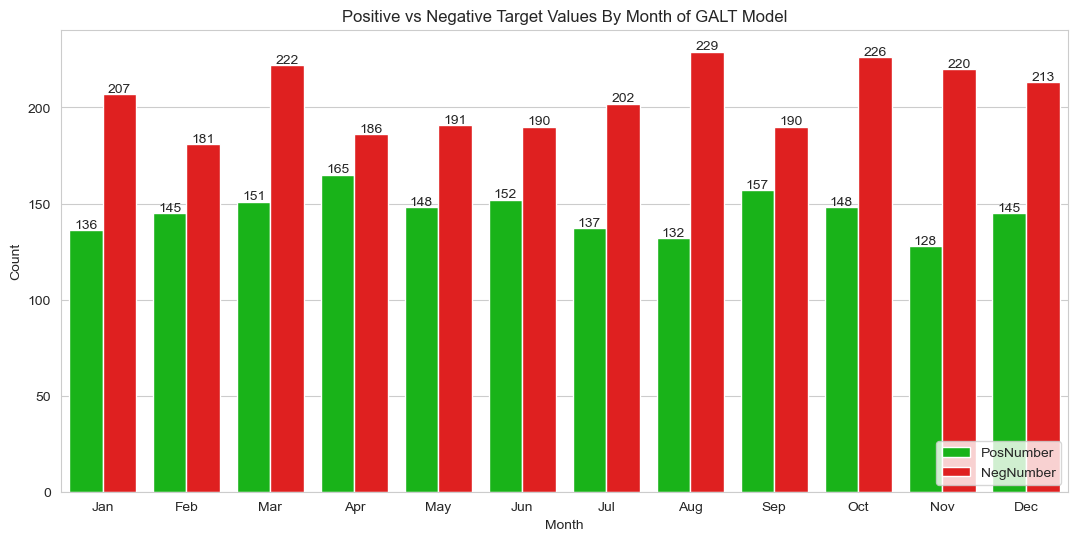

In [136]:
# plotting the GALT Target variable
print("Number of Positive vs. Negative Target Values By Month of GALT Model:")
plot_target_by_month("GALT", galt)

Percentage of Positive vs Negative Target Values of GALT Ticker


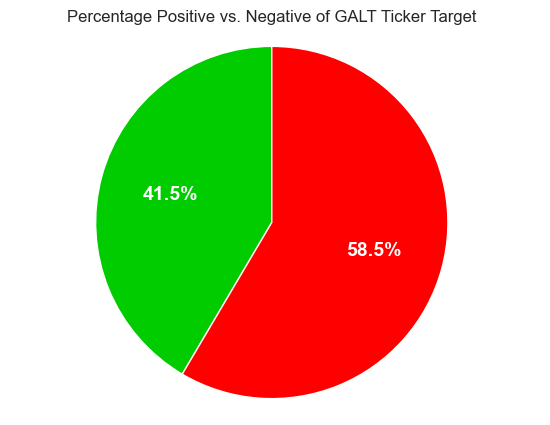

In [140]:
print("Percentage of Positive vs Negative Target Values of GALT Ticker")
display_target_values("GALT", galt)

Number of Times GALT Ticker's Target is Positive Per Year:


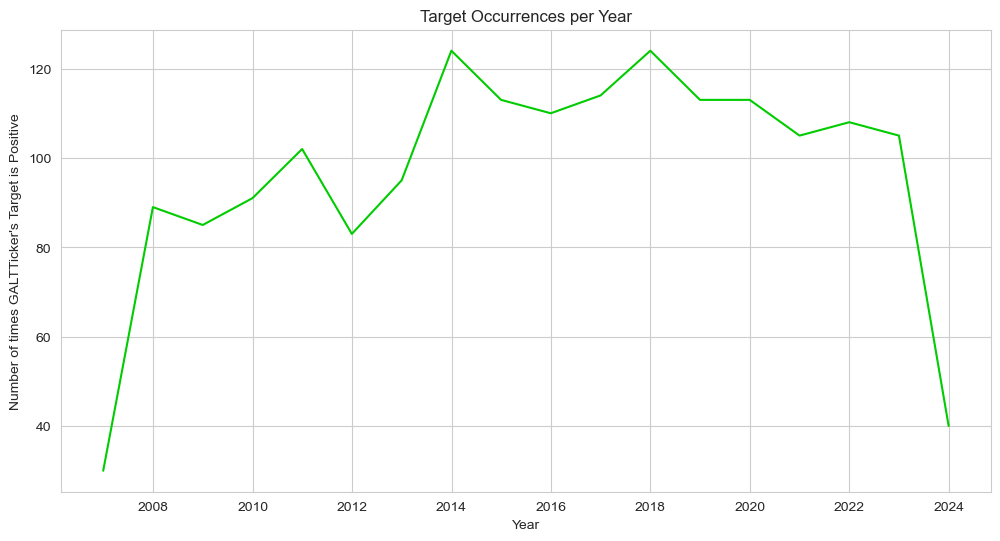

In [146]:
print("Number of Times GALT Ticker's Target is Positive Per Year:")
plot_target_by_year("GALT", galt)

**Data Prep / EDA for AMZN:**

In [98]:
# Prepare AMZN data for modeling
amzn = amzn_raw.copy()

# Delete the Dividends and Stock Splits variables
del amzn["Dividends"]
del amzn["Stock Splits"]

# Creating the Tomorrow variable in the dataframe
amzn["Tomorrow"] = amzn["Close"].shift(-1)

# Creating the Target variable in the dataframe
amzn["Target"] = (amzn["Tomorrow"] > amzn["Close"]).astype(int)

# creating moving average day-splits list
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_avgs = amzn.rolling(horizon).mean()
    
    ratio_col = f"Close Ratio {horizon}"
    amzn[ratio_col] = amzn["Close"] / rolling_avgs["Close"]
    
    trend_col = f"Trend {horizon}"
    amzn[trend_col] = amzn.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_col, trend_col]
    
amzn = amzn.dropna()

print('AMZN prep completed\n')

# Showing the summary statistics of the AMZN dataframe
print("Summary statistics for the AMZN ticker:")
amzn.describe()

AMZN prep completed

Summary statistics for the AMZN ticker:


,Open,High,Low,Close,Volume,Tomorrow,Target,Close Ratio 2,Trend 2,Close Ratio 5,Trend 5,Close Ratio 60,Trend 60,Close Ratio 250,Trend 250,Close Ratio 1000,Trend 1000
count,5534.000000,5534.000000,5534.000000,5534.000000,5.534000e+03,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000
mean,37.242889,37.683021,36.758889,37.229529,1.204776e+08,37.248108,0.513010,1.000433,1.025660,1.001893,2.564872,1.030169,30.768341,1.120265,128.122696,1.455492,510.363029
std,50.469696,51.067940,49.800988,50.431299,9.696991e+07,50.436828,0.499876,0.013871,0.704528,0.030139,1.087382,0.112252,3.679482,0.242023,8.857505,0.466178,26.080087
min,0.295500,0.305000,0.275500,0.298500,1.762600e+07,0.298500,0.000000,0.858669,0.000000,0.777864,0.000000,0.529960,21.000000,0.347979,108.000000,0.166824,468.000000
25%,2.416250,2.464000,2.379125,2.422250,6.627250e+07,2.423000,0.000000,0.994347,1.000000,0.987562,2.000000,0.969984,28.000000,0.972447,121.000000,1.217319,491.000000
50%,11.050500,11.234000,10.905000,11.065750,9.876100e+07,11.070750,1.000000,1.000277,1.000000,1.001686,3.000000,1.032454,31.000000,1.116870,128.000000,1.542545,503.000000
75%,54.702250,55.406126,54.405374,55.149874,1.446275e+08,55.243999,1.000000,1.006602,2.000000,1.016133,3.000000,1.090865,33.000000,1.250463,134.000000,1.780004,530.000000
max,187.199997,188.654007,184.839493,186.570496,2.086584e+09,186.570496,1.000000,1.147017,2.000000,1.275063,5.000000,1.547594,42.000000,1.935378,155.000000,2.441645,563.000000


Number of Positive vs. Negative Target Values By Month of AMZN Model:


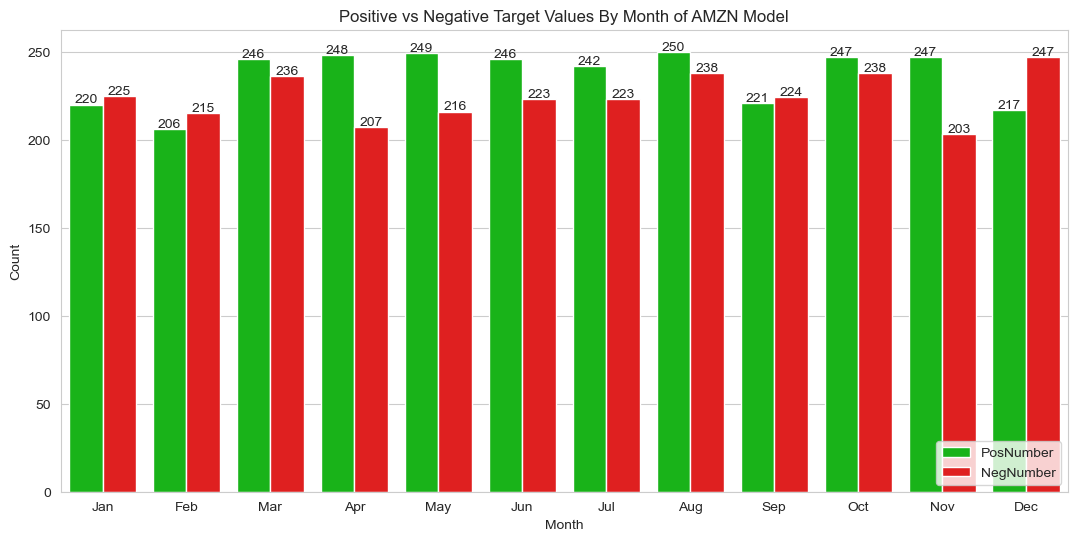

In [137]:
# plotting the AMZN Target variable
print("Number of Positive vs. Negative Target Values By Month of AMZN Model:")
plot_target_by_month("AMZN", amzn)

Percentage of Positive vs Negative Target Values of AMZN Ticker


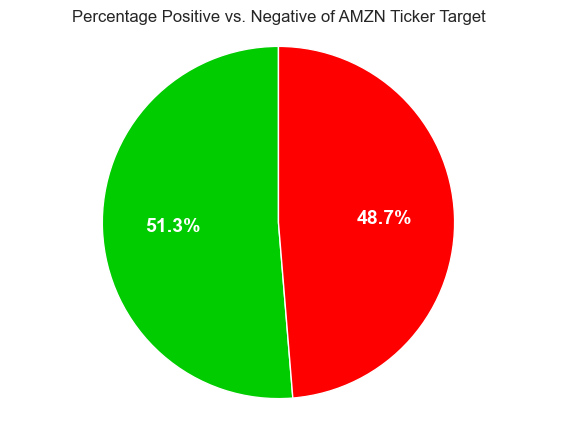

In [141]:
print("Percentage of Positive vs Negative Target Values of AMZN Ticker")
display_target_values("AMZN", amzn)

Number of Times AMZN Ticker's Target is Positive Per Year:


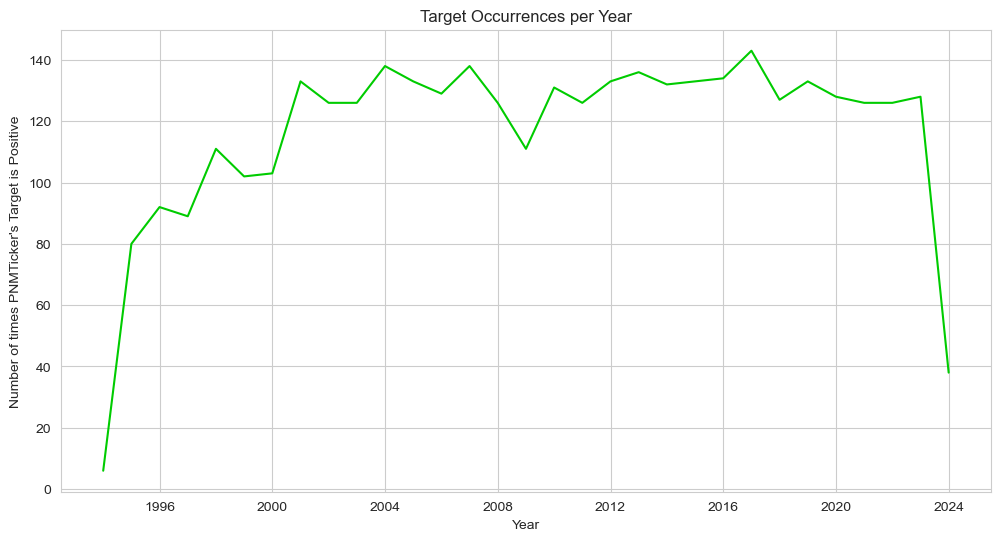

In [147]:
print("Number of Times AMZN Ticker's Target is Positive Per Year:")
plot_target_by_year("PNM", pnm)

## Modeling

We were most interested in the results that were produced by a random forest classifier model. We had used other models, such as Prophet and ARIMA, but ultimately, we found that the random forest classifier gave us a more realistic and measurable prediction: whether a stock will increase in price or not. Additionally, we found that the random forest was much more resistant to over-fitting issues, which we believe is very important to avoid with stock market modeling. Lastly, the random forest model is much better for predicting non-linear trends, and though stock prices are linear on a day-to-day basis, they do not follow these trends long-term.

To help improve our modeling, we created to functions, **predict** and **backtest** which aim to fit the model and strengthen the predictions that are generated.

With our random forest classifier, we chose the following hyperparameters: n_estimators = 200, min_samples_split = 50, and random_state = 1. We found that our models were compiling quickly enough to test their accuracy and still produce sound results with the 200 random trees that are generated as a result of the **n_estimators** parameter. With **min_samples_split** set to 50, we ensure that our trees do not exceed a certain depth and overfit our model.

We had guidance in building our model and model-strengthening functions from this video:
https://www.youtube.com/watch?v=1O_BenficgE

The **predict** function that we created below allows us to easily fit our model on the training data and generate predictions from the model. The function returns a pandas dataframe which has 2 variables, the first of which is the **Target** variable from the test data, and the second is the list of predictions made by the model.

Instead of using the default 50% confidence threshold when predicting if a stock will increase in price, we are now using a 55% threshold to ensure that we have more certainty that the price will actually increase on the following day.

In [39]:
# defining the predict method used for generating a series of predicted values for the target variable
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.55] = 1
    preds[preds < 0.55] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

Below, we have created a **backtest** function, which will strengthen our predictions using the random forest model. The function takes several parameters: **data, model, predictors, start, and stop**.

This function generates predictions for our random forest model for ten different years, which makes us much more confident in our classification results.

We set the **step** parameter to 250 because this represents a full calendar year of trading days. Similarly, we set the **start** parameter to 2500 because this represents a full decade of trading days. Ultimately, the **start** parameter specifies that the random forest will be modeled on ten years worth of stock ticker data. The **step** parameter specifies that we are iteratively training the model on each trading year.

In [40]:
# defining the backtest method which does...
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

**Modeling with the PNM Ticker Data:**

In [100]:
# generate the random forest classifier model for the PNM data
pnm_model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [111]:
pnm_model

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [101]:
# backtest our model to judge the accuracy of its predictions
pnm_predictions = backtest(pnm, pnm_model, new_predictors)

In [84]:
# showing the value counts of the predictions for PNM
pnm_predictions["Predictions"].value_counts()

0.0    3098
1.0    1800
Name: Predictions, dtype: int64

In [85]:
# showing how accurately the model predicted the stock to increase for PNM
precision_score(pnm_predictions["Target"], pnm_predictions["Predictions"])

0.5061111111111111

**Modeling with the GALT Ticker Data:**

In [88]:
# creating the random forest classifier for the GALT data
galt_model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [110]:
galt_model

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [89]:
# generating the dataframe of GALT predictions
galt_predictions = backtest(galt, galt_model, new_predictors)

In [90]:
# showing the value counts of the predictions for GALT
galt_predictions["Predictions"].value_counts()

0.0    629
1.0     72
Name: Predictions, dtype: int64

In [91]:
# showing how accurately the model predicted the stock to increase for GALT
precision_score(galt_predictions["Target"], galt_predictions["Predictions"])

0.5138888888888888

**Modeling with the AMZN Ticker Data:**

In [92]:
# creating the random forest classifier for the AMZN data
amzn_model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [109]:
amzn_model

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=1)

In [93]:
# generating the dataframe of AMZN predictions
amzn_predictions = backtest(amzn, amzn_model, new_predictors)

In [95]:
# showing the value counts of the predictions for AMZN
amzn_predictions["Predictions"].value_counts()

0.0    2438
1.0     596
Name: Predictions, dtype: int64

In [94]:
# showing how accurately the model predicted the stock to increase for AMZN
precision_score(amzn_predictions["Target"], amzn_predictions["Predictions"])

0.5335570469798657

## Performance Results

In [113]:
def show_confusion_matrix(model_name, y_actual, y_predicted):
    labels = [0,1]
    conf_mat = confusion_matrix(y_actual, y_predicted, labels=labels)
    conf_mat_df = pd.DataFrame(conf_mat, index=labels, columns=labels)
    vals = ["Correct Negative", "Incorrect Negative", 
            "Correct Positive", "Incorrect Positive"]
    figure = plt.figure(figsize=(8, 3))
    sns.set_style("whitegrid")
    ax = sns.barplot(x=vals, y = [conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]])
    for i, val in enumerate([conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]]):
        ax.text(i, val+1, str(val), ha='center')
    plt.xlabel("Prediction Result")
    plt.ylabel("Count")
    plt.title("Number of Correct and Incorrect Predictions of " + model_name + " Model")

In [114]:
def compute_performance_metrics(model_name, y_actual, y_predicted):
    metrics_df = pd.DataFrame(index = ["Accuracy", "Precision", "Recall", "F1_score"], columns = [model_name])
    
    # Calculate Accuracy
    acc = accuracy_score(y_actual, y_predicted)
    metrics_df.loc["Accuracy", model_name] = acc.round(4)

    # Calculate Precision
    precision = precision_score(y_actual, y_predicted)
    metrics_df.loc["Precision", model_name] = precision.round(4)

    # Calculate Recall
    recall = recall_score(y_actual, y_predicted)
    metrics_df.loc["Recall", model_name] = recall.round(4)

    # Calculate F1 Score
    f1 = f1_score(y_actual, y_predicted)
    metrics_df.loc["F1_score", model_name] = f1.round(4)
    
    return metrics_df

**Performance Results for the PNM Ticker Model:**

PNM Model Confusion Matrix:


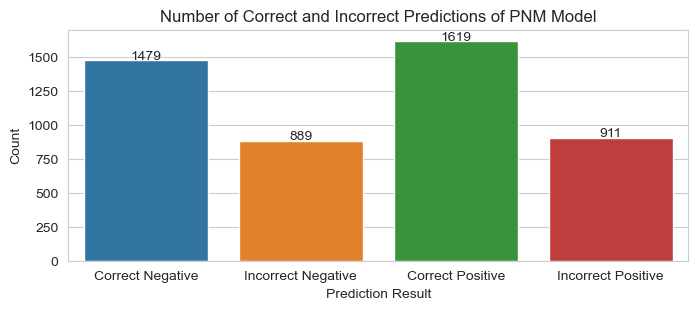

In [117]:
# creating a confusion matrix for the PNM data
print("PNM Model Confusion Matrix:")
show_confusion_matrix("PNM", pnm_predictions["Target"], pnm_predictions["Predictions"])

In [120]:
# showing the model performance metrics for PNM
print("PNM Model Performance Metrics:")
compute_performance_metrics("PNM", pnm_predictions["Target"], pnm_predictions["Predictions"])

PNM Model Performance Metrics:


,PNM
Accuracy,0.488
Precision,0.5061
Recall,0.3601
F1_score,0.4208


**GALT Ticker Model Performance:**

GALT Model Confusion Matrix:


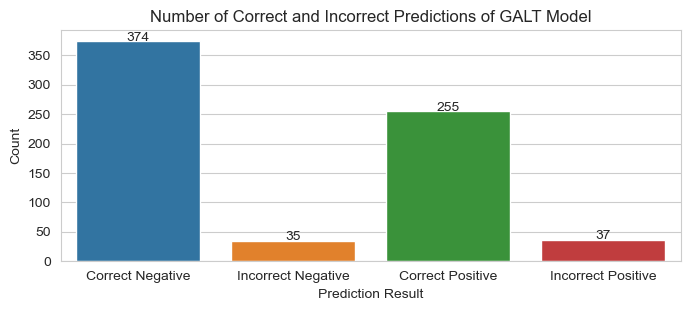

In [121]:
# creating a confusion matrix for the GALT data
print("GALT Model Confusion Matrix:")
show_confusion_matrix("GALT", galt_predictions["Target"], galt_predictions["Predictions"])

In [125]:
# showing the model performance metrics for GALT
print("GALT Model Performance Metrics:")
compute_performance_metrics("GALT", galt_predictions["Target"], galt_predictions["Predictions"])

GALT Model Performance Metrics:


,GALT
Accuracy,0.5863
Precision,0.5139
Recall,0.1267
F1_score,0.2033


**AMZN Ticker Model Performance:**

AMZN Model Confusion Matrix:


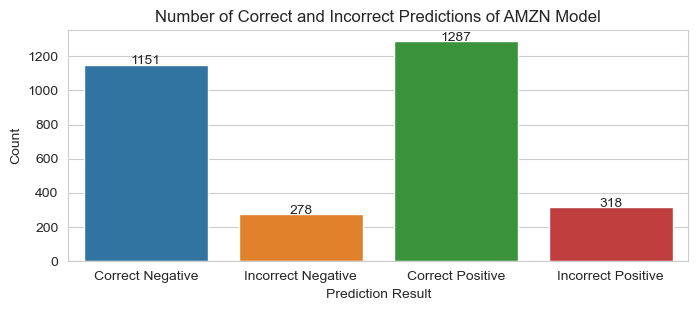

In [126]:
# creating a confusion matrix for the PNM data
print("AMZN Model Confusion Matrix:")
show_confusion_matrix("AMZN", amzn_predictions["Target"], amzn_predictions["Predictions"])

In [127]:
# showing the model performance metrics for AMZN
print("AMZN Model Performance Metrics:")
compute_performance_metrics("GALT", amzn_predictions["Target"], amzn_predictions["Predictions"])

AMZN Model Performance Metrics:


,GALT
Accuracy,0.4842
Precision,0.5336
Recall,0.1981
F1_score,0.289


## Discussion

Our project presented an interesting set of problems for us to solve. Probably the easiest task for us was sourcing our
data. We found the yfinance python package which handily downloads decades of financial data in just a few
lines of code. The data provided by yfinance is almost always very neat and does not require too much additional preprocessing.

During the modeling phase of our project, we tested and evaluated several different models. Originally, we were using the
Prophet model developed by Facebook to try and predict the adjusted closing prices of stocks. We also used the ARIMA model in an attempt to improve upon our previous results, however our tests were much more consistent when using the Prophet model. Eventually, we decided to pivot our goal to simply determining if a stock will move up or down the following day. If this model is to be used with a trading application, it is far more valuable for us to have a binary buy or sell output based on whether stock is predicted to go up or down. With this in mind, we then decided to move to a Random Forest Classifier model, which ultimately was able to produce semi-accurate and actionable predictions.

## Conclusions

As can be seen in the reported precisions above, our random forest classifier is able to successfully decide if a stock
will increase or decrease over 50% of the time for PNM, GALT, and AMZN. Surprisingly, we achieved our highest precision
score with AMZN at around 0.54. In our performance results we found the reason for the error in predictability is because
of the number of false positives, which is relatively high, for each of the stock tickers that we modeled.

With the current performance metrics that our model is producing, we cannot recommend purely buying and selling stock based
off the model's predictions. What we can safely say is that our model has proven itself to be a valid tool in evaluating
potential day-to-day trends of a stocks price. One very good use for our model would be if it were used in a suite of metrics
for determining stock movement. Our previous work with the Prophet model has proven that it also has validity in
determining stock movement, and potentially utilizing these 2 models together could lead to higher precision scores for
our predictions.